In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from devito import *
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

from plotting import *  

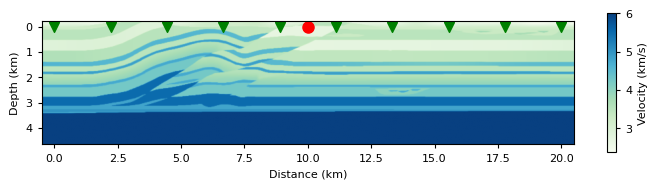

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# === Load data ===
slice_2d = np.load("overthrust_i3_455.npy")

# Convert velocity to km/s if it's in m/s
slice_2d_km = slice_2d / 1000.0

# === Grid parameters ===
n1, n2 = slice_2d.shape
d1 = d2 = 25.0  # meters
x = np.linspace(0, (n2 - 1) * d2 / 1000, n2)  # km
z = np.linspace(0, (n1 - 1) * d1 / 1000, n1)  # km

# === Source and geophones ===
x_source = x[n2 // 2]  # source at 1/4 of profile
num_geophones = 10
x_geophones = np.linspace(x[0], x[-1], num_geophones)

# === Extend borders to show source/geophones ===
z_min = -0.2  # extend 0.1 km above surface
z_max = z[-1]
x_min = x[0] - 0.5  # extend 0.1 km to the left
x_max = x[-1] + 0.5  # extend 0.1 km to the right

# === Plot ===
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(slice_2d_km, cmap="GnBu", origin="upper",
               extent=[x_min, x_max, z_max, z_min])  # note reversed for depth

# Smaller colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.35, aspect=15)
cbar.set_label("Velocity (km/s)")

# Plot source and geophones
ax.plot(x_source, 0, color='red', marker='o', markersize=8, label='Source')        
ax.scatter(x_geophones, np.zeros_like(x_geophones), color='green', marker='v', s=50) 

ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (km)")
plt.tight_layout()
plt.show()

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


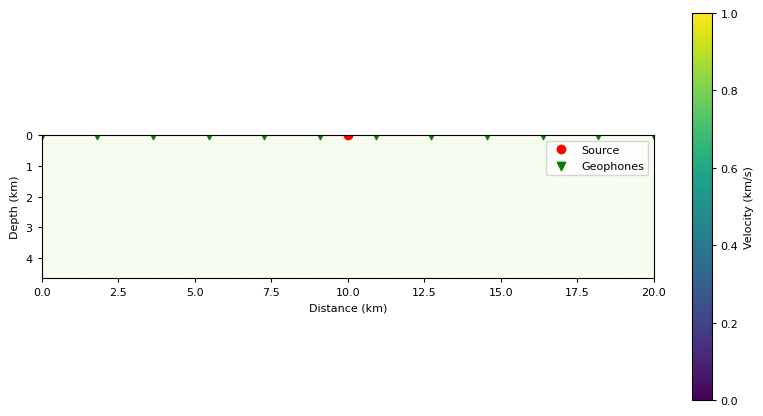

Maximum wavefield amplitude in the domain: 0.0


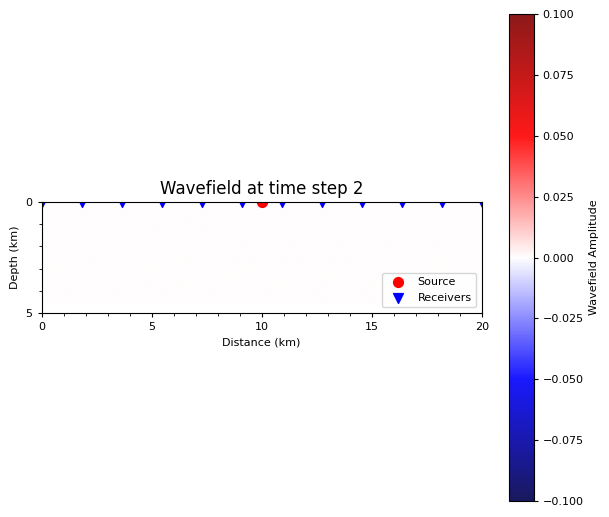

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from devito import *
from examples.seismic import Model, plot_velocity, demo_model
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from examples.seismic import TimeAxis
from examples.seismic import Receiver
from examples.seismic import RickerSource
from devito import Operator
from matplotlib.animation import FuncAnimation

# ======================================================
# 0. Load 2D velocity model (slice_2d must be defined)
# ======================================================
# nz, nx = slice_2d.shape  # depth, width
# v = slice_2d.astype(np.float32) / 1000.0  # convert to km/s
# Instead of slice_2d, define a homogeneous velocity
nz, nx = slice_2d.shape  # keep the same size for consistency
v_homo = np.ones((nz, nx), dtype=np.float32) * 2000.0  # 2000 m/s constant velocity
v = v_homo #/ 1000.0  # convert to km/s

# ======================================================
# 1. Define the seismic model
# ======================================================
model = Model(
    origin=(0., 0.),
    shape=(nx, nz),          # match velocity array
    spacing=(25.0, 25.0),    # grid spacing in meters
    nbl=40,                  # absorbing boundaries
    bcs="damp",
    vp=v.T,                  # Devito expects (nx, nz)
    space_order=8
)

# ======================================================
# 2. Time axis
# ======================================================
t0 = 0.0
tn = 5.0  # seconds: enough to see the wave propagate in a small 2D slice
dt = model.critical_dt * 0.5  # reduce to ensure stability
time_range = TimeAxis(start=t0, stop=tn, step=dt)


# ======================================================
# 3. Source and receivers
# ======================================================
f0 = 5.0  # lower frequency -> longer wavelength -> visible on coarse grid

src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range, npoint=1)
src.coordinates.data[0, 0] = model.domain_size[0] / 2
src.coordinates.data[0, 1] = 0.0

# Receivers
nreceivers = 12
rec_coords = np.zeros((nreceivers, 2))
rec_coords[:, 0] = np.linspace(0, model.domain_size[0], nreceivers)  # evenly spaced
rec_coords[:, 1] = 0.0                                              # at surface

rec = Receiver(name='rec', grid=model.grid, time_range=time_range,
               npoint=nreceivers, coordinates=rec_coords)

# ======================================================
# 4. TimeFunction to store wavefield
# ======================================================
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8,
                 save=time_range.num)

# ======================================================
# 5. PDE, source injection, and receiver interpolation
# ======================================================
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)

op_fwd = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# ======================================================
# 6. Run the simulation
# ======================================================
op_fwd(dt=dt)

# ======================================================
# 7. Extract velocity field (without absorbing boundaries)
# ======================================================
velocity_field = model.vp.data[tuple(slice(model.nbl, -model.nbl) for _ in range(2))]
extent = [0, model.domain_size[0]/1000,  # x in km
          model.domain_size[1]/1000, 0]   # z in km, depth downward

plt.figure(figsize=(8,4))
plt.imshow(velocity_field.T/1000, cmap="GnBu", origin="upper", extent=extent)
plt.plot(src.coordinates.data[0,0]/1000, src.coordinates.data[0,1]/1000, 'ro', label='Source')
plt.scatter(rec.coordinates.data[:,0]/1000, rec.coordinates.data[:,1]/1000, 
            c='green', marker='v', label='Geophones')
plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
plt.colorbar(label="Velocity (km/s)")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 8. Extract wavefield at a time instant
# ======================================================
# Slice to remove absorbing boundaries
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()
print(f"Maximum wavefield amplitude in the domain: {max_val}")


# Ensure time_instant is within saved steps
time_instant = min(100, u.data.shape[0]-1)
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T  # transpose for correct orientation

# ======================================================
# 9. Plot combined figure: velocity + wavefield + geometry
# ======================================================
plt.figure(figsize=(6, 5))

# Background: velocity model (greyscale)
#plt.imshow(velocity_field.T/1000, origin="upper", cmap="Greys", extent=extent)

# Overlay: wavefield (seismic colormap, semi-transparent)
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.8, vmax=max_val*0.8, extent=extent, alpha=0.9)
plt.colorbar(label="Wavefield Amplitude")

# Source and receivers
plt.scatter(src.coordinates.data[:, 0]/1000, src.coordinates.data[:, 1]/1000,
            c="red", marker="o", s=50, label="Source")
plt.scatter(rec.coordinates.data[:, 0]/1000, rec.coordinates.data[:, 1]/1000,
            c="blue", marker="v", s=50, label="Receivers")

# Axes configuration
ax = plt.gca()
ax.set_xticks(np.arange(0, model.domain_size[0]/1000 + 1, 5))  # km
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(np.arange(0, model.domain_size[1]/1000 + 1, 5))  # km
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
plt.legend(loc="lower right")
plt.title(f"Wavefield at time step {time_instant}", fontsize=12)
plt.tight_layout()
plt.show()

In [63]:
time_range

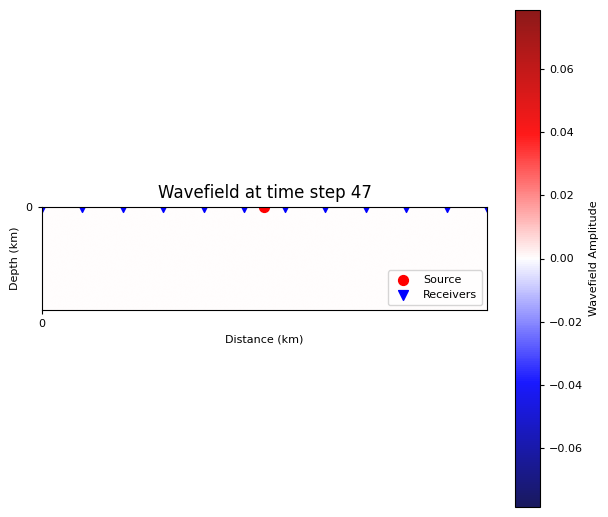

In [65]:
# Ensure time_instant is within saved steps
time_instant = min(100, u.data.shape[0]-1)
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T  # transpose for correct orientation

# ======================================================
# 9. Plot combined figure: velocity + wavefield + geometry
# ======================================================
plt.figure(figsize=(6, 5))

# Background: velocity model (greyscale)
#plt.imshow(velocity_field.T/1000, origin="upper", cmap="Greys", extent=extent)

# Overlay: wavefield (seismic colormap, semi-transparent)
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.8, vmax=max_val*0.8, extent=extent, alpha=0.9)
plt.colorbar(label="Wavefield Amplitude")

# Source and receivers
plt.scatter(src.coordinates.data[:, 0]/1000, src.coordinates.data[:, 1]/1000,
            c="red", marker="o", s=50, label="Source")
plt.scatter(rec.coordinates.data[:, 0]/1000, rec.coordinates.data[:, 1]/1000,
            c="blue", marker="v", s=50, label="Receivers")

# Axes configuration
ax = plt.gca()
ax.set_xticks(np.arange(0, model.domain_size[0]/1000 + 1, 5))  # km
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_yticks(np.arange(0, model.domain_size[1]/1000 + 1, 5))  # km
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.xlabel("Distance (km)")
plt.ylabel("Depth (km)")
plt.legend(loc="lower right")
plt.title(f"Wavefield at time step {time_instant}", fontsize=12)
plt.tight_layout()
plt.show()

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.10 s


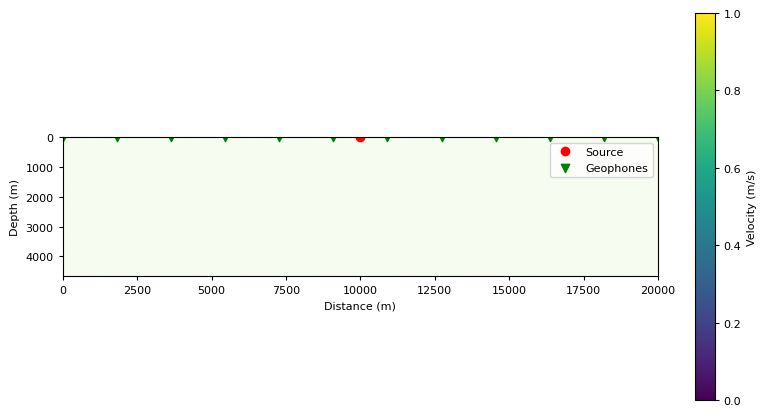

Maximum wavefield amplitude in the domain: 326.2471923828125


/tmp/ipykernel_44151/2140883175.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


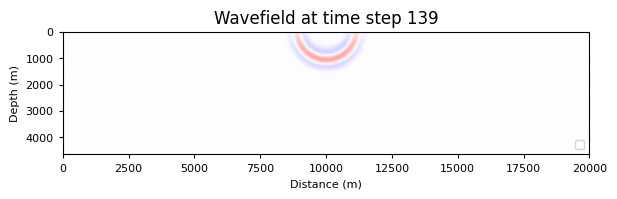

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from devito import *
from examples.seismic import Model, TimeAxis, Receiver, RickerSource
from matplotlib.ticker import MultipleLocator

# ======================================================
# 0. Homogeneous velocity model (in m/s)
# ======================================================
nz, nx = slice_2d.shape  # depth, width
v_homo = np.ones((nz, nx), dtype=np.float32) * 2000.0  # 2000 m/s
v = v_homo

# ======================================================
# 1. Define the seismic model
# ======================================================
nbl = 100  # increase the boundary thickness
model = Model(
    origin=(0., 0.),
    shape=(nx, nz),
    spacing=(25.0, 25.0),
    nbl=nbl,
    bcs="damp",
    vp=v.T,
    space_order=8
)
# ======================================================
# 2. Time axis
# ======================================================
t0 = 0.0
tn = 3.0  # seconds
dt = model.critical_dt 
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# ======================================================
# 3. Source and receivers
# ======================================================
f0 = 3.0  # Hz
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range, npoint=1)
src.coordinates.data[0, 0] = model.domain_size[0] / 2
src.coordinates.data[0, 1] = 0.0

nreceivers = 12
rec_coords = np.zeros((nreceivers, 2))
rec_coords[:, 0] = np.linspace(0, model.domain_size[0], nreceivers)
rec_coords[:, 1] = 0.0
rec = Receiver(name='rec', grid=model.grid, time_range=time_range,
               npoint=nreceivers, coordinates=rec_coords)

# ======================================================
# 4. TimeFunction to store wavefield
# ======================================================
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8,
                 save=time_range.num)

# ======================================================
# 5. PDE, source injection, and receiver interpolation
# ======================================================
pde = model.m * u.dt2 - u.laplace + 2.0 * model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
op_fwd = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# ======================================================
# 6. Run the simulation
# ======================================================
op_fwd(dt=dt)

# ======================================================
# 7. Extract velocity field (without absorbing boundaries)
# ======================================================
velocity_field = model.vp.data[tuple(slice(model.nbl, -model.nbl) for _ in range(2))]
extent = [0, model.domain_size[0], model.domain_size[1], 0]  # in meters

plt.figure(figsize=(8,4))
plt.imshow(velocity_field.T, cmap="GnBu", origin="upper", extent=extent)
plt.plot(src.coordinates.data[0,0], src.coordinates.data[0,1], 'ro', label='Source')
plt.scatter(rec.coordinates.data[:,0], rec.coordinates.data[:,1], 
            c='green', marker='v', label='Geophones')
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Velocity (m/s)")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 8. Extract wavefield at a time instant
# ======================================================
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()
print(f"Maximum wavefield amplitude in the domain: {max_val}")

time_instant = int(u.data.shape[0] * 0.30)  # 90% of the simulation
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T

# ======================================================
# 9. Plot wavefield
# ======================================================
plt.figure(figsize=(6, 5))
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.8, vmax=max_val*0.8, extent=extent)
#plt.colorbar(label="Wavefield Amplitude")
#plt.scatter(src.coordinates.data[:, 0], src.coordinates.data[:, 1],
#            c="red", marker="o", s=50, label="Source")
#plt.scatter(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1],
#            c="blue", marker="v", s=50, label="Receivers")

ax = plt.gca()
 

plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.legend(loc="lower right")
plt.title(f"Wavefield at time step {time_instant}", fontsize=12)
plt.tight_layout()
plt.show()


Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.63 s


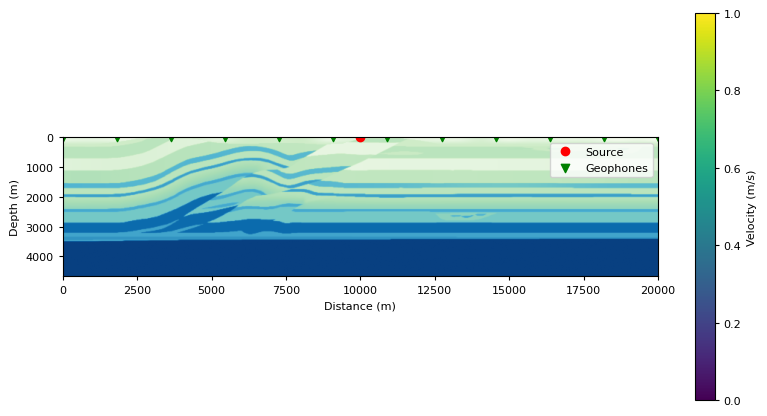

Maximum wavefield amplitude in the domain: 295.708251953125


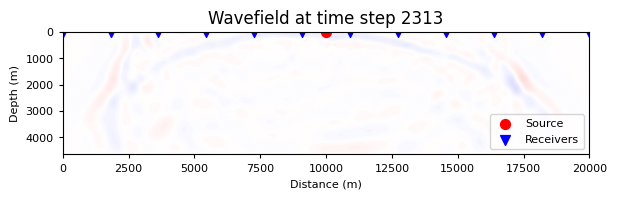

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from devito import *
from examples.seismic import Model, TimeAxis, Receiver, RickerSource
from matplotlib.ticker import MultipleLocator

# ======================================================
# 0. Velocity model from slice_2d (in m/s)
# ======================================================
nz, nx = slice_2d.shape  # depth, width
v = slice_2d.astype(np.float32)  # keep in m/s

# ======================================================
# 1. Define the seismic model
# ======================================================
model = Model(
    origin=(0., 0.),
    shape=(nx, nz),
    spacing=(25.0, 25.0),  # meters
    nbl=40,
    bcs="damp",
    vp=v.T,  # Devito expects (nx, nz)
    space_order=8
)

# ======================================================
# 2. Time axis
# ======================================================
t0 = 0.0
tn = 5.0  # seconds
dt = model.critical_dt * 0.5
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# ======================================================
# 3. Source and receivers
# ======================================================
f0 = 4.0  # Hz
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range, npoint=1)
src.coordinates.data[0, 0] = model.domain_size[0] / 2
src.coordinates.data[0, 1] = 0.0

nreceivers = 12
rec_coords = np.zeros((nreceivers, 2))
rec_coords[:, 0] = np.linspace(0, model.domain_size[0], nreceivers)
rec_coords[:, 1] = 0.0
rec = Receiver(name='rec', grid=model.grid, time_range=time_range,
               npoint=nreceivers, coordinates=rec_coords)

# ======================================================
# 4. TimeFunction to store wavefield
# ======================================================
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8,
                 save=time_range.num)

# ======================================================
# 5. PDE, source injection, and receiver interpolation
# ======================================================
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
op_fwd = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# ======================================================
# 6. Run the simulation
# ======================================================
op_fwd(dt=dt)

# ======================================================
# 7. Extract velocity field (without absorbing boundaries)
# ======================================================
velocity_field = model.vp.data[tuple(slice(model.nbl, -model.nbl) for _ in range(2))]
extent = [0, model.domain_size[0], model.domain_size[1], 0]  # meters

plt.figure(figsize=(8,4))
plt.imshow(velocity_field.T, cmap="GnBu", origin="upper", extent=extent)
plt.plot(src.coordinates.data[0,0], src.coordinates.data[0,1], 'ro', label='Source')
plt.scatter(rec.coordinates.data[:,0], rec.coordinates.data[:,1], 
            c='green', marker='v', label='Geophones')
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Velocity (m/s)")
plt.legend()
plt.tight_layout()
plt.show()

# ======================================================
# 8. Extract wavefield at a time instant
# ======================================================
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()
print(f"Maximum wavefield amplitude in the domain: {max_val}")

time_instant = u.data.shape[0] // 2  # middle of simulation
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T

# ======================================================
# 9. Plot wavefield
# ======================================================
plt.figure(figsize=(6, 5))
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.8, vmax=max_val*0.8, extent=extent)
plt.scatter(src.coordinates.data[:, 0], src.coordinates.data[:, 1],
            c="red", marker="o", s=50, label="Source")
plt.scatter(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1],
            c="blue", marker="v", s=50, label="Receivers")

 

plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.legend(loc="lower right")
plt.title(f"Wavefield at time step {time_instant}", fontsize=12)
plt.tight_layout()
plt.show()


Maximum wavefield amplitude in the domain: 295.708251953125


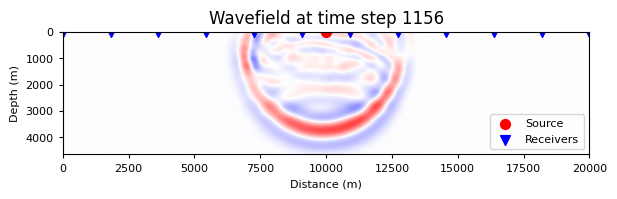

In [120]:
# ======================================================
# 8. Extract wavefield at a time instant
# ======================================================
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()
print(f"Maximum wavefield amplitude in the domain: {max_val}")

time_instant = int(u.data.shape[0] * 0.25)  # 10% of the simulation
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T

# ======================================================
# 9. Plot wavefield
# ======================================================
plt.figure(figsize=(6, 5))
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.2, vmax=max_val*0.2, extent=extent)
plt.scatter(src.coordinates.data[:, 0], src.coordinates.data[:, 1],
            c="red", marker="o", s=50, label="Source")
plt.scatter(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1],
            c="blue", marker="v", s=50, label="Receivers")

ax = plt.gca()


plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.legend(loc="lower right")
plt.title(f"Wavefield at time step {time_instant}", fontsize=12)
plt.tight_layout()
plt.show()


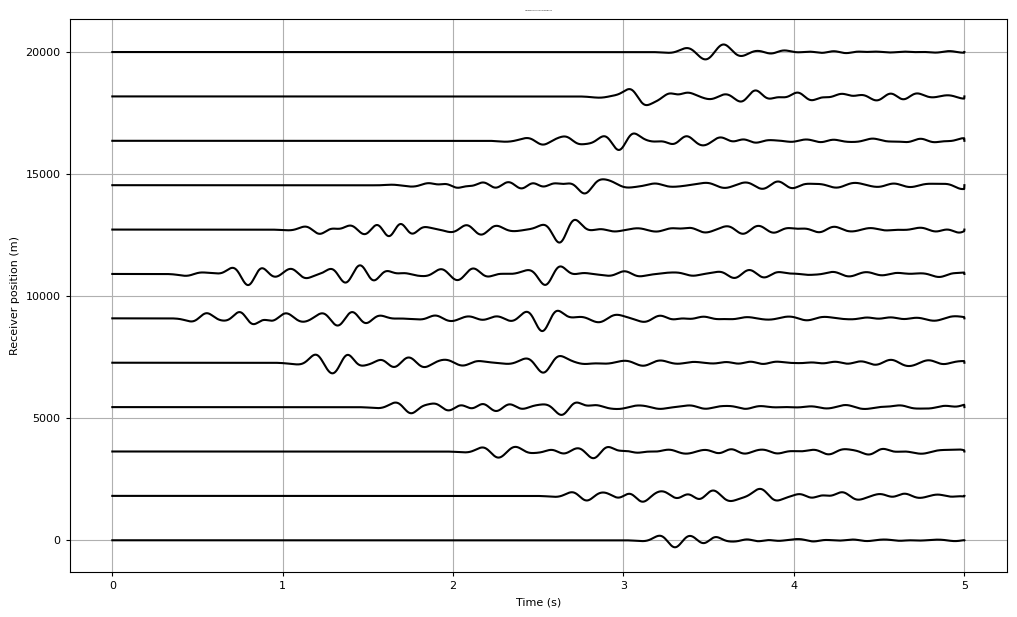

In [94]:
# ======================================================
# Plot seismograms recorded by geophones
# ======================================================
plt.figure(figsize=(10, 6))

# time axis
time_vec = time_range.time_values  # seconds

# offset positions (x) of each geophone
offsets = rec.coordinates.data[:, 0]

# Normalize for plotting if needed
for i in range(nreceivers):
    trace = rec.data[:, i] *100
    plt.plot(time_vec, trace + offsets[i], color='black')  # shift by receiver position

plt.xlabel("Time (s)")
plt.ylabel("Receiver position (m)")
plt.title("Seismograms recorded by geophones")
plt.grid(True)
plt.tight_layout()
plt.show()